In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.signal import find_peaks
from ShelvingAnalysis import ShelvingAnalysis
from tqdm.notebook import tqdm

df1 = pd.read_csv('ShelvingIntensityRawDataAmp10.csv')
ShelvingIntensityAverageArray1 = df1['ShelvingIntensityAverageAmp10'].tolist()
ShelvingIntensityUncertaintyArray1 = df1['ShelvingIntensityUncertaintyAmp10'].tolist()
ShelvingIntensityAverageArray_cleaned1 = np.delete(ShelvingIntensityAverageArray1, [11,22,33,44,55,66,77,88])
ShelvingIntensityUncertaintyArray_cleaned1 = np.delete(ShelvingIntensityUncertaintyArray1, [11,22,33,44,55,66,77,88])

df2 = pd.read_csv('ShelvingIntensityRawDataAmp05.csv')
ShelvingIntensityAverageArray2 = df2['ShelvingIntensityAverageAmp05'].tolist()
ShelvingIntensityUncertaintyArray2 = df2['ShelvingIntensityUncertaintyAmp05'].tolist()
ShelvingIntensityAverageArray_cleaned2 = np.delete(ShelvingIntensityAverageArray2, [11,22,33,44,55,66,77,88])
ShelvingIntensityUncertaintyArray_cleaned2 = np.delete(ShelvingIntensityUncertaintyArray2, [11,22,33,44,55,66,77,88])

df3 = pd.read_csv('ShelvingIntensityRawDataAmp025.csv')
ShelvingIntensityAverageArray3 = df3['ShelvingIntensityAverageAmp025'].tolist()
ShelvingIntensityUncertaintyArray3 = df3['ShelvingIntensityUncertaintyAmp025'].tolist()
ShelvingIntensityAverageArray_cleaned3 = np.delete(ShelvingIntensityAverageArray3, [11,22,33,44,55,66])
ShelvingIntensityUncertaintyArray_cleaned3 = np.delete(ShelvingIntensityUncertaintyArray3, [11,22,33,44,55,66])

ShelvingIntensityAverageArray_cleaned3_padded = np.pad(ShelvingIntensityAverageArray_cleaned3, (20,0), mode = 'constant', constant_values = 0)
ShelvingIntensityUncertaintyArray_cleaned3_padded = np.pad(ShelvingIntensityUncertaintyArray_cleaned3, (20,0), mode = 'constant', constant_values = 0)

In [2]:
### ---------------------- INITIALISE PLOTTING STYLE ---------------------- ###

## WINDOWS: On your .ipynb, import this plotting_style by adding in and uncommenting the following lines:
import matplotlib.pyplot as plt
import sys
sys.path.append('C:/Users/Michael/Dropbox/AION/Projects')  # Replace with the relevant path that contains this script
from plotting_style import set_plotting_style
set_plotting_style()

## MAC: On your .ipynb, import this plotting_style by adding in and uncommenting the following lines:
# import matplotlib.pyplot as plt
# import sys
# sys.path.append('/Users/michael/Dropbox/AION/Projects')  # Replace with the relevant path that contains this script
# from plotting_style import set_plotting_style
# set_plotting_style()


import matplotlib.pyplot as plt

print('Initialising plotting style...')

def set_plotting_style():
    plt.rc("font", family = 'Arial', size=10)
    plt.rc('axes', labelsize=20, titlesize = 20, labelpad=5)
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)
    plt.rc('legend', fontsize=15)

print('Success! Plotting style initialised.')


Initialising plotting style...
Success! Plotting style initialised.
Initialising plotting style...
Success! Plotting style initialised.


Text(0.5, 0, 'Frequency Detuning ($\\times$10$^3$ $\\Gamma_{red}$)')

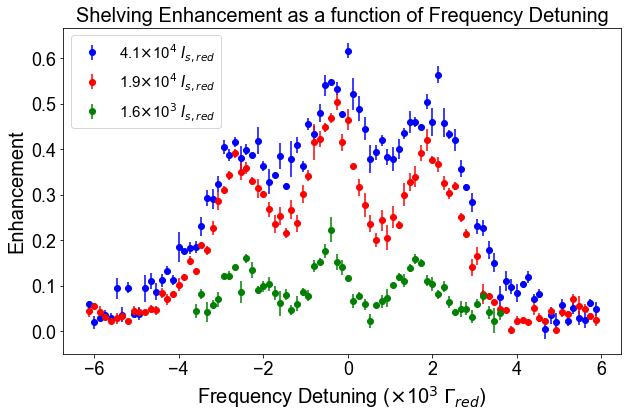

In [3]:
### ---------------------- PLOTTING ---------------------- ###

plt.figure(figsize=(10,6))

# convert x-axis to frequency detuning space in MHz, where the biggest shelving intensity is 0 detuning
FrequencyDetuning = np.arange(-np.argmax(ShelvingIntensityAverageArray_cleaned1), np.shape(ShelvingIntensityAverageArray_cleaned1)[0]-np.argmax(ShelvingIntensityAverageArray_cleaned1))
FrequencyDetuningGamma = FrequencyDetuning/7.5 # convert to units of x 10e3 Gamma_red (7.5kHz)

# plt.errorbar(range(len(ShelvingIntensityAverageArray)), ShelvingIntensityAverageArray, yerr=ShelvingIntensityUncertaintyArray, fmt='o')
plt.errorbar(FrequencyDetuningGamma, ShelvingIntensityAverageArray_cleaned1, yerr=ShelvingIntensityUncertaintyArray_cleaned1, fmt='o',color='blue', label=r'4.1$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyDetuningGamma, ShelvingIntensityAverageArray_cleaned2, yerr=ShelvingIntensityUncertaintyArray_cleaned2, fmt='o', color='red', label=r'1.9$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyDetuningGamma[-72:-17], ShelvingIntensityAverageArray_cleaned3[:-16], yerr=ShelvingIntensityUncertaintyArray_cleaned3[:-16], fmt='o', color='green',label=r'1.6$\times$10$^3$ $I_{s,red}$')
plt.legend(loc='upper left')

plt.title('Shelving Enhancement as a function of Frequency Detuning')
plt.ylabel(r'Enhancement')
plt.xlabel(r'Frequency Detuning ($\times$10$^3$ $\Gamma_{red}$)')

# plt.savefig('ShelvingEnhancementVsFrequencyDetuning.png', dpi=1200)
# plt.savefig('ShelvingEnhancementVsFrequencyDetuning.pdf',dpi=1200)

In [4]:
PowerAmp10 = 65 #mW
IntensityAmp10 = 2*PowerAmp10/(np.pi*0.58**2) #mW/cm^2
IntensityAmp10SaturationRed = IntensityAmp10*1e3/3

IntensityAmp10SaturationRed

41003.05707876813

In [5]:
IntensityAmp10

123.00917123630438

In [6]:
PowerAmp05 = 30 #mW
IntensityAmp05 = 2*PowerAmp05/(np.pi*0.58**2) #mW/cm^2
IntensityAmp05SaturationRed = IntensityAmp05*1e3/3

IntensityAmp05SaturationRed

18924.487882508365

In [7]:
IntensityAmp05

56.7734636475251

In [8]:
PowerAmp025 = 2.5 #mW
IntensityAmp025 = 2*PowerAmp025/(np.pi*0.58**2) #mW/cm^2
IntensityAmp025SaturationRed = IntensityAmp025*1e3/3

IntensityAmp025SaturationRed

1577.040656875697

In [9]:
IntensityAmp025

4.7311219706270915

Text(0.5, 0, 'Frequency Detuning (MHz)')

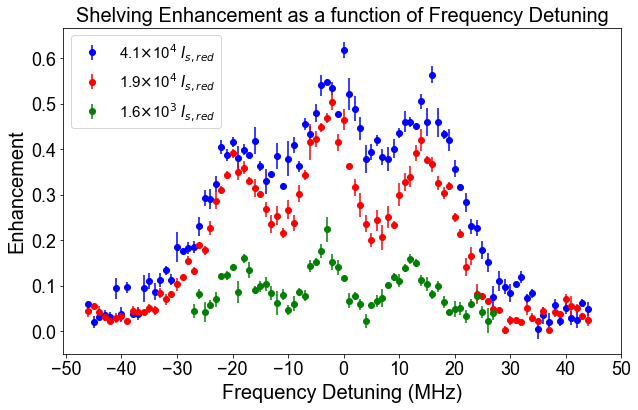

In [10]:
### ---------------------- PLOTTING ---------------------- ###

plt.figure(figsize=(10,6))

# convert x-axis to frequency detuning space in MHz, where the biggest shelving intensity is 0 detuning
FrequencyDetuning = np.arange(-np.argmax(ShelvingIntensityAverageArray_cleaned1), np.shape(ShelvingIntensityAverageArray_cleaned1)[0]-np.argmax(ShelvingIntensityAverageArray_cleaned1))
FrequencyDetuningGamma = FrequencyDetuning/7.5 # convert to units of x 10e3 Gamma_red (7.5kHz)

# plt.errorbar(range(len(ShelvingIntensityAverageArray)), ShelvingIntensityAverageArray, yerr=ShelvingIntensityUncertaintyArray, fmt='o')
plt.errorbar(FrequencyDetuning, ShelvingIntensityAverageArray_cleaned1, yerr=ShelvingIntensityUncertaintyArray_cleaned1, fmt='o',color='blue', label=r'4.1$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyDetuning, ShelvingIntensityAverageArray_cleaned2, yerr=ShelvingIntensityUncertaintyArray_cleaned2, fmt='o', color='red', label=r'1.9$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyDetuning[-72:-17], ShelvingIntensityAverageArray_cleaned3[:-16], yerr=ShelvingIntensityUncertaintyArray_cleaned3[:-16], fmt='o', color='green',label=r'1.6$\times$10$^3$ $I_{s,red}$')
plt.legend(loc='upper left')

plt.xticks(np.arange(-50, 51, 10))
plt.title('Shelving Enhancement as a function of Frequency Detuning')
plt.ylabel(r'Enhancement')
plt.xlabel(r'Frequency Detuning (MHz)')

# plt.savefig('ShelvingEnhancementVsFrequencyDetuning2.png', dpi=1200)
# plt.savefig('ShelvingEnhancementVsFrequencyDetuning2.pdf',dpi=1200)

Text(0.5, 0, 'Frequency offset from cavity (MHz)')

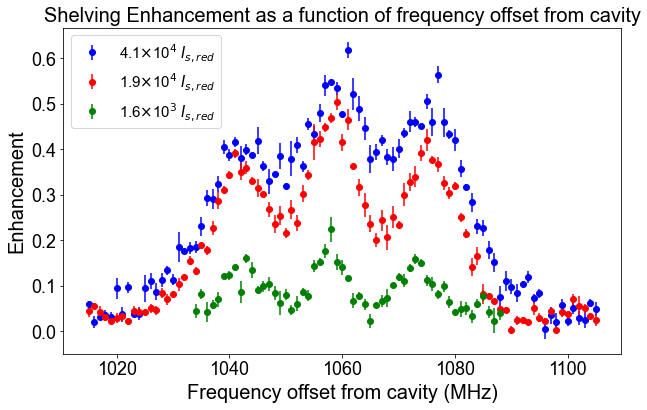

In [32]:
### ---------------------- CHANGE X AXIS TO UNITS OF MIRNY AND DPAOM FREQ ---------------------- ###

DPAOM_FREQ = 347.5 * 2 # in MHz
MIRNY_FREQ = np.arange(420,511,1) # in MHz
SUSERVO_AOM_OFFSET = 100 # in MHz

FrequencyOffsetFromCavity = MIRNY_FREQ + DPAOM_FREQ - SUSERVO_AOM_OFFSET

### ---------------------- PLOTTING ---------------------- ###

plt.figure(figsize=(10,6))

# convert x-axis to frequency detuning space in MHz, where the biggest shelving intensity is 0 detuning
FrequencyDetuning = np.arange(-np.argmax(ShelvingIntensityAverageArray_cleaned1), np.shape(ShelvingIntensityAverageArray_cleaned1)[0]-np.argmax(ShelvingIntensityAverageArray_cleaned1))
FrequencyDetuningGamma = FrequencyDetuning/7.5 # convert to units of x 10e3 Gamma_red (7.5kHz)

# plt.errorbar(range(len(ShelvingIntensityAverageArray)), ShelvingIntensityAverageArray, yerr=ShelvingIntensityUncertaintyArray, fmt='o')
plt.errorbar(FrequencyOffsetFromCavity, ShelvingIntensityAverageArray_cleaned1, yerr=ShelvingIntensityUncertaintyArray_cleaned1, fmt='o',color='blue', label=r'4.1$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyOffsetFromCavity, ShelvingIntensityAverageArray_cleaned2, yerr=ShelvingIntensityUncertaintyArray_cleaned2, fmt='o', color='red', label=r'1.9$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyOffsetFromCavity[-72:-17], ShelvingIntensityAverageArray_cleaned3[:-16], yerr=ShelvingIntensityUncertaintyArray_cleaned3[:-16], fmt='o', color='green',label=r'1.6$\times$10$^3$ $I_{s,red}$')
plt.legend(loc='upper left')

# plt.xticks(np.arange(-50, 51, 10))
plt.title('Shelving Enhancement as a function of frequency offset from cavity')
plt.ylabel(r'Enhancement')
plt.xlabel(r'Frequency offset from cavity (MHz)')


# Fitting

C:\Users\Michael\AppData\Local\Temp/ipykernel_28168/3890491074.py:9: RuntimeWarning: overflow encountered in multiply
  return amp * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))


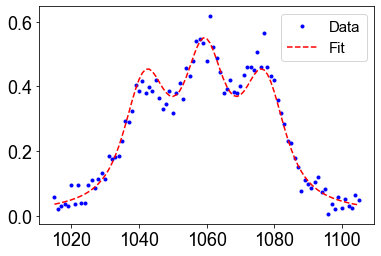

Fitted parameters:  [1.18585044e+01 1.05937392e+03 6.38809893e-03 8.03064129e+00
 7.43215884e+00 1.75959512e+01 3.00029469e+00 5.37402098e+00]
Amplitude of the central Voigt profile: 11.858504411166548
Central frequency of the central Voigt profile: 1059.3739162197814
Standard deviation of the Gaussian part of the central Voigt profile: 0.006388098928446972
Half-width at half-maximum of the Lorentzian part of the central Voigt profile: 8.030641291055467
Amplitude of the side Voigt profiles: 7.432158841695629
Frequency separation of the side Voigt profiles from the central frequency: 17.59595115438672
Standard deviation of the Gaussian part of the side Voigt profiles: 3.0002946902737144
Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: 5.374020981630825


In [37]:
import numpy as np
from scipy.special import wofz
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the Voigt profile
def voigt(x, amp, mu, sigma, gamma):
    z = ((x - mu) + 1j*gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

# Define a combination of three Voigt profiles: one central and two side ones
def combined_voigt(x, amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s):
    # Central Voigt profile
    central = voigt(x, amp_c, mu_c, sigma_c, gamma_c)
    # Side Voigt profiles (symmetrically placed)
    side_left = voigt(x, amp_s, mu_c - delta_s, sigma_s, gamma_s)
    side_right = voigt(x, amp_s, mu_c + delta_s, sigma_s, gamma_s)
    # Combine them
    return central + side_left + side_right

# Generate some synthetic data (for demonstration)
x_data1 = FrequencyOffsetFromCavity
y_data = ShelvingIntensityAverageArray_cleaned1

# Initial guesses for fitting parameters: [amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s]
# The fitting parameters are in the order of the function arguments, explained below:
# amp_c: amplitude of the central Voigt profile
# mu_c: central frequency of the central Voigt profile
# sigma_c: standard deviation of the Gaussian part of the central Voigt profile
# gamma_c: half-width at half-maximum of the Lorentzian part of the central Voigt profile
# amp_s: amplitude of the side Voigt profiles
# delta_s: frequency separation of the side Voigt profiles from the central frequency
# sigma_s: standard deviation of the Gaussian part of the side Voigt profiles
# gamma_s: half-width at half-maximum of the Lorentzian part of the side Voigt profiles
initial_guesses = [15.0, 1060.0, 1.0, 0.5, 0.5, 5.0, 1.0, 0.5]

# Fit the combined Voigt profile to the data
popt1, pcov = curve_fit(combined_voigt, x_data1, y_data, p0=initial_guesses)

# Plot the result
plt.plot(x_data1, y_data, 'b.', label='Data')
plt.plot(x_data1, combined_voigt(x_data1, *popt1), 'r--', label='Fit')
plt.legend()
plt.show()

# Print the fitted parameters
print("Fitted parameters: ", popt1)

# List them out individually
print(f"Amplitude of the central Voigt profile: {popt1[0]}")
print(f"Central frequency of the central Voigt profile: {popt1[1]}")
print(f"Standard deviation of the Gaussian part of the central Voigt profile: {popt1[2]}")
print(f"Half-width at half-maximum of the Lorentzian part of the central Voigt profile: {popt1[3]}")
print(f"Amplitude of the side Voigt profiles: {popt1[4]}")
print(f"Frequency separation of the side Voigt profiles from the central frequency: {popt1[5]}")
print(f"Standard deviation of the Gaussian part of the side Voigt profiles: {popt1[6]}")
print(f"Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {popt1[7]}")


C:\Users\Michael\AppData\Local\Temp/ipykernel_28168/1118587954.py:9: RuntimeWarning: overflow encountered in true_divide
  return amp * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))


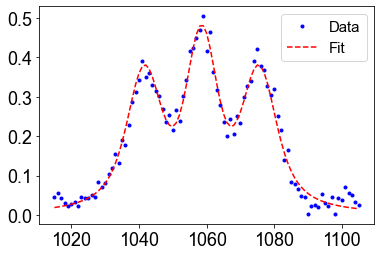

Fitted parameters:  [   5.69707641 1058.5434713     3.19538961    2.54860959    6.44535766
   16.97112178    2.62885244    4.74302501]
Amplitude of the central Voigt profile: 5.697076414321834
Central frequency of the central Voigt profile: 1058.543471301707
Standard deviation of the Gaussian part of the central Voigt profile: 3.195389606613879
Half-width at half-maximum of the Lorentzian part of the central Voigt profile: 2.548609588175197
Amplitude of the side Voigt profiles: 6.4453576567943225
Frequency separation of the side Voigt profiles from the central frequency: 16.97112177966633
Standard deviation of the Gaussian part of the side Voigt profiles: 2.6288524413980836
Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: 4.743025011935332


In [38]:
import numpy as np
from scipy.special import wofz
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the Voigt profile
def voigt(x, amp, mu, sigma, gamma):
    z = ((x - mu) + 1j*gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

# Define a combination of three Voigt profiles: one central and two side ones
def combined_voigt(x, amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s):
    # Central Voigt profile
    central = voigt(x, amp_c, mu_c, sigma_c, gamma_c)
    # Side Voigt profiles (symmetrically placed)
    side_left = voigt(x, amp_s, mu_c - delta_s, sigma_s, gamma_s)
    side_right = voigt(x, amp_s, mu_c + delta_s, sigma_s, gamma_s)
    # Combine them
    return central + side_left + side_right

# Generate some synthetic data (for demonstration)
x_data2 = FrequencyOffsetFromCavity
y_data = ShelvingIntensityAverageArray_cleaned2

# Initial guesses for fitting parameters: [amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s]
# The fitting parameters are in the order of the function arguments, explained below:
# amp_c: amplitude of the central Voigt profile
# mu_c: central frequency of the central Voigt profile
# sigma_c: standard deviation of the Gaussian part of the central Voigt profile
# gamma_c: half-width at half-maximum of the Lorentzian part of the central Voigt profile
# amp_s: amplitude of the side Voigt profiles
# delta_s: frequency separation of the side Voigt profiles from the central frequency
# sigma_s: standard deviation of the Gaussian part of the side Voigt profiles
# gamma_s: half-width at half-maximum of the Lorentzian part of the side Voigt profiles
initial_guesses = [1.0, 1060.0, 1.0, 0.5, 0.5, 5.0, 1.0, 0.5]

# Fit the combined Voigt profile to the data
popt2, pcov = curve_fit(combined_voigt, x_data2, y_data, p0=initial_guesses)

# Plot the result
plt.plot(x_data2, y_data, 'b.', label='Data')
plt.plot(x_data2, combined_voigt(x_data2, *popt2), 'r--', label='Fit')
plt.legend()
plt.show()


# Print the fitted parameters
print("Fitted parameters: ", popt2)

# List them out individually
print(f"Amplitude of the central Voigt profile: {popt2[0]}")
print(f"Central frequency of the central Voigt profile: {popt2[1]}")
print(f"Standard deviation of the Gaussian part of the central Voigt profile: {popt2[2]}")
print(f"Half-width at half-maximum of the Lorentzian part of the central Voigt profile: {popt2[3]}")
print(f"Amplitude of the side Voigt profiles: {popt2[4]}")
print(f"Frequency separation of the side Voigt profiles from the central frequency: {popt2[5]}")
print(f"Standard deviation of the Gaussian part of the side Voigt profiles: {popt2[6]}")
print(f"Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {popt2[7]}")

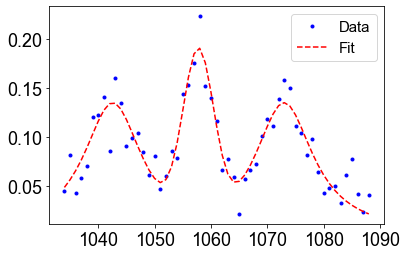

Fitted parameters:  [ 8.42995520e-01  1.05776872e+03  3.07881332e+00 -1.19277331e+00
  2.59382861e+00  1.52136105e+01  4.06415180e-05  6.27403304e+00]
Amplitude of the central Voigt profile: 0.8429955198220282
Central frequency of the central Voigt profile: 1057.7687203159198
Standard deviation of the Gaussian part of the central Voigt profile: 3.0788133212144166
Half-width at half-maximum of the Lorentzian part of the central Voigt profile: -1.192773314024313
Amplitude of the side Voigt profiles: 2.5938286092806133
Frequency separation of the side Voigt profiles from the central frequency: 15.213610537037315
Standard deviation of the Gaussian part of the side Voigt profiles: 4.064151803010482e-05
Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: 6.2740330422060735


In [53]:
import numpy as np
from scipy.special import wofz
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the Voigt profile
def voigt(x, amp, mu, sigma, gamma):
    z = ((x - mu) + 1j*gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

# Define a combination of three Voigt profiles: one central and two side ones
def combined_voigt(x, amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s):
    # Central Voigt profile
    central = voigt(x, amp_c, mu_c, sigma_c, gamma_c)
    # Side Voigt profiles (symmetrically placed)
    side_left = voigt(x, amp_s, mu_c - delta_s, sigma_s, gamma_s)
    side_right = voigt(x, amp_s, mu_c + delta_s, sigma_s, gamma_s)
    # Combine them
    return central + side_left + side_right

# Generate some synthetic data (for demonstration)
x_data3 = FrequencyOffsetFromCavity[-72:-17]
y_data = ShelvingIntensityAverageArray_cleaned3[:-16]

# Initial guesses for fitting parameters: [amp_c, mu_c, sigma_c, gamma_c, amp_s, delta_s, sigma_s, gamma_s]
# The fitting parameters are in the order of the function arguments, explained below:
# amp_c: amplitude of the central Voigt profile
# mu_c: central frequency of the central Voigt profile
# sigma_c: standard deviation of the Gaussian part of the central Voigt profile
# gamma_c: half-width at half-maximum of the Lorentzian part of the central Voigt profile
# amp_s: amplitude of the side Voigt profiles
# delta_s: frequency separation of the side Voigt profiles from the central frequency
# sigma_s: standard deviation of the Gaussian part of the side Voigt profiles
# gamma_s: half-width at half-maximum of the Lorentzian part of the side Voigt profiles
initial_guesses = [0.1, 1057.0, 3, 3, 0.1, 15, 1.0, 0.1]

# Fit the combined Voigt profile to the data
popt3, pcov = curve_fit(combined_voigt, x_data3, y_data, p0=initial_guesses)

# Plot the result
plt.plot(x_data3, y_data, 'b.', label='Data')
plt.plot(x_data3, combined_voigt(x_data3, *popt3), 'r--', label='Fit')
plt.legend()
plt.show()

# Print the fitted parameters
print("Fitted parameters: ", popt3)

# List them out individually
print(f"Amplitude of the central Voigt profile: {popt3[0]}")
print(f"Central frequency of the central Voigt profile: {popt3[1]}")
print(f"Standard deviation of the Gaussian part of the central Voigt profile: {popt3[2]}")
print(f"Half-width at half-maximum of the Lorentzian part of the central Voigt profile: {popt3[3]}")
print(f"Amplitude of the side Voigt profiles: {popt3[4]}")
print(f"Frequency separation of the side Voigt profiles from the central frequency: {popt3[5]}")
print(f"Standard deviation of the Gaussian part of the side Voigt profiles: {popt3[6]}")
print(f"Half-width at half-maximum of the Lorentzian part of the side Voigt profiles: {popt3[7]}")


Text(0.5, 0, 'Frequency Detuning (MHz)')

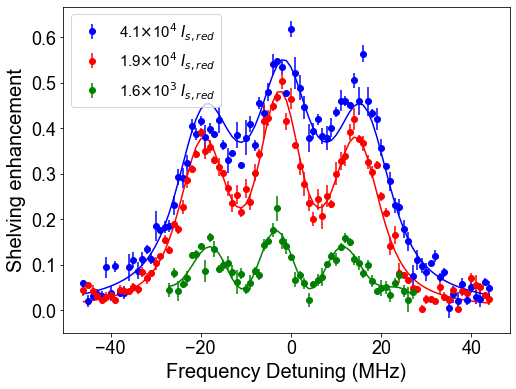

In [14]:
### ---------------------- PLOTTING ---------------------- ###

plt.figure(figsize=(8,6))

# convert x-axis to frequency detuning space in MHz, where the biggest shelving intensity is 0 detuning
FrequencyDetuning = np.arange(-np.argmax(ShelvingIntensityAverageArray_cleaned1), np.shape(ShelvingIntensityAverageArray_cleaned1)[0]-np.argmax(ShelvingIntensityAverageArray_cleaned1))
FrequencyDetuningGamma = FrequencyDetuning/7.5 # convert to units of x 10e3 Gamma_red (7.5kHz)

# plt.errorbar(range(len(ShelvingIntensityAverageArray)), ShelvingIntensityAverageArray, yerr=ShelvingIntensityUncertaintyArray, fmt='o')
plt.errorbar(FrequencyDetuning, ShelvingIntensityAverageArray_cleaned1, yerr=ShelvingIntensityUncertaintyArray_cleaned1, fmt='o',color='blue', label=r'4.1$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyDetuning, ShelvingIntensityAverageArray_cleaned2, yerr=ShelvingIntensityUncertaintyArray_cleaned2, fmt='o', color='red', label=r'1.9$\times$10$^4$ $I_{s,red}$')
plt.errorbar(FrequencyDetuning[-72:-17], ShelvingIntensityAverageArray_cleaned3[:-16], yerr=ShelvingIntensityUncertaintyArray_cleaned3[:-16], fmt='o', color='green',label=r'1.6$\times$10$^3$ $I_{s,red}$')

plt.plot(FrequencyDetuning, combined_voigt(FrequencyDetuning, *popt1), 'b-')
plt.plot(FrequencyDetuning, combined_voigt(FrequencyDetuning, *popt2), 'r-')
plt.plot(FrequencyDetuning[-72:-17], combined_voigt(FrequencyDetuning[-72:-17], *popt3), 'g-')

plt.legend()

# plt.xticks(np.arange(-50, 51, 10))
# plt.title('Shelving Enhancement as a \n function of Frequency Detuning')
plt.ylabel(r'Shelving enhancement')
plt.xlabel(r'Frequency Detuning (MHz)')

# plt.savefig('ShelvingEnhancementVsFrequencyDetuning2Fitted.png', dpi=1200)
# plt.savefig('ShelvingEnhancementVsFrequencyDetuning2Fitted.pdf',dpi=1200)